In [1]:
import pandas as pd
import numpy as np
import boto3
import dotenv
from dotenv import load_dotenv
import os
import seaborn as sns
import matplotlib.pyplot as plt

aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")
region = os.getenv("AWS_DEFAULT_REGION")
bucket = os.getenv("AWS_S3_BUCKET")

In [2]:
print("Bucket utilisé :", bucket)
print("Clé AWS présente :", aws_access_key_id is not None)

Bucket utilisé : projet-incendie
Clé AWS présente : True


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df=pd.read_csv('output/corse_Dataset_modele.csv', sep=';', encoding='utf-8', low_memory=False)
  

C:\Users\m_bar\AppData\Local\Temp\ipykernel_154012\2513794024.py:2: DtypeWarning: Columns (60) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('output/corse_Dataset_modele.csv', sep=';', encoding='utf-8')


,ville,Date,POSTE,RR,DRR,TN,HTN,TX,HTX,TM,TMNX,TNSOL,TN50,TAMPLI,TNTXM,FFM,FXI,DXI,HXI,FXY,DXY,HXY,FXI3S,HXI3S,UN,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ORAG,BRUME,ETPMON,ETPGRILLE,Code INSEE_x,Code Postal_x,moyenne precipitations année,moyenne precipitations mois,moyenne evapotranspiration année,moyenne evapotranspiration mois,moyenne vitesse vent année,moyenne vitesse vent mois,moyenne temperature année,moyenne temperature mois,Département,Code INSEE_y,latitude,longitude,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surfaces non boisées (m2),Type de peuplement,Nature,Feux,Code Postal_y,Commune
0,Afa,2006-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2A,2A001,41.983809,8.796663,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,20167.0,AFA
1,Afa,2006-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2A,2A001,41.983809,8.796663,4000.0,0.0,0.0,NaN,NaN,NaN,0.0,1.0,Involontaire (travaux),1.0,20167.0,AFA
2,Afa,2006-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2A,2A001,41.983809,8.796663,1000.0,0.0,0.0,NaN,NaN,NaN,0.0,1.0,Involontaire (particulier),1.0,20167.0,AFA
3,Afa,2007-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2A,2A001,41.983809,8.796663,8000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,20167.0,AFA
4,Afa,2007-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2A,2A001,41.983809,8.796663,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,20167.0,AFA


In [4]:
# Changement de type de la colonne Feux
df['Feux'] = df['Feux'].astype(int)

In [5]:
# Changement d'emplacement de la colonne Date
cols = [col for col in df.columns if col != 'Date']
cols.append('Date')
df = df[cols]

In [7]:
# Vérification du nombre de feux
df['Feux'].value_counts()

Feux
0    248927
1      8906
Name: count, dtype: int64

In [ ]:
# Mise en place de la colonne décompte avant le feu suivant

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['ville', 'Date'])

def days_until_next_fire(group):
    # Dates où il y a un feu, sinon NaT
    feu_dates = group['Date'].where(group['Feux'] == 1)

    # On inverse la série pour faire un forward fill à rebours (pour chaque date, la prochaine date feu)
    next_feu_dates = feu_dates[::-1].ffill()[::-1]

    # Calcul du delta en jours entre la prochaine date feu et la date actuelle
    delta_days = (next_feu_dates - group['Date']).dt.days

    # Pour les lignes où Feux==1, mettre 0 (par sécurité)
    delta_days[group['Feux'] == 1] = 0

    return delta_days

df['décompte'] = df.groupby('ville').apply(days_until_next_fire).reset_index(level=0, drop=True)

# print(df[['ville', 'Date', 'Feux', 'décompte']].head(10))

  ville       Date  Feux  décompte
0   Afa 2006-06-09     1       0.0
1   Afa 2006-06-13     1       0.0
2   Afa 2006-06-21     1       0.0
3   Afa 2007-10-04     1       0.0
4   Afa 2007-10-09     1       0.0
5   Afa 2008-09-06     1       0.0
6   Afa 2009-06-10     1       0.0
7   Afa 2009-06-19     1       0.0
8   Afa 2010-03-21     1       0.0
9   Afa 2010-05-23     1       0.0


C:\Users\m_bar\AppData\Local\Temp\ipykernel_154012\3698583184.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['décompte'] = df.groupby('ville').apply(days_until_next_fire).reset_index(level=0, drop=True)


In [9]:
# Modification de l'emplacement du nom de la commune dans le dataset pour plus de lisibilité

cols = list(df.columns)
cols.remove('ville')
new_position = len(cols) - 2
cols.insert(new_position, 'ville')

df = df[cols]


In [ ]:
df.drop(columns=['POSTE', 'Code INSEE_y', 'Commune', 'Département', 'latitude', 'longitude'], inplace=True)


,RR,DRR,TN,HTN,TX,HTX,TM,TMNX,TNSOL,TN50,TAMPLI,TNTXM,FFM,FXI,DXI,HXI,FXY,DXY,HXY,FXI3S,HXI3S,UN,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ORAG,BRUME,ETPMON,ETPGRILLE,Code INSEE_x,Code Postal_x,moyenne precipitations année,moyenne precipitations mois,moyenne evapotranspiration année,moyenne evapotranspiration mois,moyenne vitesse vent année,moyenne vitesse vent mois,moyenne temperature année,moyenne temperature mois,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surfaces non boisées (m2),Type de peuplement,Nature,Feux,Code Postal_y,ville,Date,décompte
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2006-06-09,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,0.0,0.0,NaN,NaN,NaN,0.0,1.0,Involontaire (travaux),1,20167.0,Afa,2006-06-13,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,0.0,0.0,NaN,NaN,NaN,0.0,1.0,Involontaire (particulier),1,20167.0,Afa,2006-06-21,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2007-10-04,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2007-10-09,0.0


### Import des coordonnées après le rajout du décompte

In [ ]:
gps=pd.read_csv('https://projet-incendie.s3.eu-west-3.amazonaws.com/coordonnees_corses.csv')


,ville,latitude,longitude
0,Ajaccio,41.926399,8.737603
1,San Giuliano,42.314870,9.493203
2,Asco,42.454277,9.034178
3,Barbaggio,42.689740,9.377380
4,Bastelica,42.001623,9.049484


In [ ]:
df_merge = df.merge(gps, 
                    on="ville", 
                    how="left")


,RR,DRR,TN,HTN,TX,HTX,TM,TMNX,TNSOL,TN50,TAMPLI,TNTXM,FFM,FXI,DXI,HXI,FXY,DXY,HXY,FXI3S,HXI3S,UN,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ORAG,BRUME,ETPMON,ETPGRILLE,Code INSEE_x,Code Postal_x,moyenne precipitations année,moyenne precipitations mois,moyenne evapotranspiration année,moyenne evapotranspiration mois,moyenne vitesse vent année,moyenne vitesse vent mois,moyenne temperature année,moyenne temperature mois,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surfaces non boisées (m2),Type de peuplement,Nature,Feux,Code Postal_y,ville,Date,décompte,latitude,longitude
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2006-06-09,0.0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,0.0,0.0,NaN,NaN,NaN,0.0,1.0,Involontaire (travaux),1,20167.0,Afa,2006-06-13,0.0,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,0.0,0.0,NaN,NaN,NaN,0.0,1.0,Involontaire (particulier),1,20167.0,Afa,2006-06-21,0.0,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2007-10-04,0.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2007-10-09,0.0,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2008-09-06,0.0,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2009-06-10,0.0,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2009-06-19,0.0,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2010-03-21,0.0,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2010-05-23,0.0,NaN,NaN


In [14]:
df_merge['Feux'].value_counts()

Feux
0    248927
1      8906
Name: count, dtype: int64

In [ ]:
# Création de la colonne évènement pour indiquer si un feu a eu lieu
df_merge['évènement'] = df_merge['Feux'] == 1



,RR,DRR,TN,HTN,TX,HTX,TM,TMNX,TNSOL,TN50,TAMPLI,TNTXM,FFM,FXI,DXI,HXI,FXY,DXY,HXY,FXI3S,HXI3S,UN,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ORAG,BRUME,ETPMON,ETPGRILLE,Code INSEE_x,Code Postal_x,moyenne precipitations année,moyenne precipitations mois,moyenne evapotranspiration année,moyenne evapotranspiration mois,moyenne vitesse vent année,moyenne vitesse vent mois,moyenne temperature année,moyenne temperature mois,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surfaces non boisées (m2),Type de peuplement,Nature,Feux,Code Postal_y,ville,Date,décompte,latitude,longitude,évènement
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2006-06-09,0.0,NaN,NaN,True
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,0.0,0.0,NaN,NaN,NaN,0.0,1.0,Involontaire (travaux),1,20167.0,Afa,2006-06-13,0.0,NaN,NaN,True
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,0.0,0.0,NaN,NaN,NaN,0.0,1.0,Involontaire (particulier),1,20167.0,Afa,2006-06-21,0.0,NaN,NaN,True
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2007-10-04,0.0,NaN,NaN,True
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2007-10-09,0.0,NaN,NaN,True
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2008-09-06,0.0,NaN,NaN,True
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2009-06-10,0.0,NaN,NaN,True
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2009-06-19,0.0,NaN,NaN,True
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2010-03-21,0.0,NaN,NaN,True
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167.0,Afa,2010-05-23,0.0,NaN,NaN,True


In [20]:
df_merge['ville'].isna().sum()

0

### Traitement des latitudes et longitudes manquante

In [21]:
mask = df_merge['latitude'].isna()
df_merge_nan = df_merge[mask]


In [22]:
df_merge_nan.latitude.isna().sum()

8181

# Traitement des villes où ils manquent des coordonnées GPS

In [23]:
# export du fichier contenant les villes manquantes 
# nombre_unique = df_merge_nan['ville']
# nombre_unique.to_csv('nombre_unique')

In [ ]:
news_gps = pd.read_csv('corse_new_gps.csv')
# on renomme la colonne qui va servir au merge
news_gps = news_gps.rename(columns={'properties.name':'ville'})
# on supprime les colonnes inutiles
news_gps = news_gps.drop(news_gps.columns[[0,1,3]], axis=1)
# Fusionner les deux DataFrames sur la colonne 'ville'
df_combined = df_merge.merge(news_gps, on='ville', how='left', suffixes=('', '_y'))
# Remplacer les valeurs manquantes dans df1 par celles de df2
df_combined['latitude'] = df_combined['latitude_y'].combine_first(df_combined['latitude'])
df_combined['longitude'] = df_combined['longitude_y'].combine_first(df_combined['longitude'])
# Supprimer les colonnes supplémentaires créées par la fusion
df_combined = df_combined.drop(columns=['latitude_y', 'longitude_y'])
df_merge = df_combined
# il restait 256 lignes sans localisation gps que l'on supprime
df_merge = df_merge.dropna(subset=['latitude', 'longitude'])


In [28]:
# Création de la colone Feu prévu pour le modèle Survival
df_merge.loc[:, "Feu prévu"] = df_merge["décompte"].notna().astype(int)


C:\Users\m_bar\AppData\Local\Temp\ipykernel_154012\266067901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge.loc[:, "Feu prévu"] = df_merge["décompte"].notna().astype(int)


In [29]:
# Vérification des valeurs de feu à venir
df_merge['Feu prévu'].value_counts()

Feu prévu
1    157446
0    100197
Name: count, dtype: int64

# Creation de nouvelles colonnes pour le modèle survival 
### colonne Feu prévu
### compteur jour vers prochain feu
### compteur feu log
### compteur feu carré
### nombre de feu par an/ville
### nombre de feu par mois/ville
### nombre de jour sans pluie consécutif
### nombre de jour avec une t°c supérieur à 30°c consécutif
### évapotranspiration Potentielle journalière moyenne sur 7jrs

In [31]:

# S'assurer que la date est bien au bon format
df_merge["Date"] = pd.to_datetime(df_merge["Date"])

# Trier le DataFrame par ville et date
df_merge = df_merge.sort_values(by=["ville", "Date"]).reset_index(drop=True)

# Nouvelle colonne initialisée à NaN
df_merge["compteur jours vers prochain feu"] = pd.NA

# Traitement par ville
for ville, groupe in df_merge.groupby("ville"):
    groupe = groupe.sort_values("Date")
    indices_feux = groupe[groupe["évènement"] == True].index.tolist()
    
    for i in range(len(indices_feux) - 1):
        debut = indices_feux[i]
        fin = indices_feux[i + 1]
        
        # Remplir les jours entre les deux feux avec un compteur croissant
        for j, idx in enumerate(range(debut, fin)):
            df_merge.loc[idx, "compteur jours vers prochain feu"] = j
# # nombre de jour sans feu + log et carré

df_merge['compteur feu log'] = df_merge['compteur jours vers prochain feu'].apply(lambda x: np.log1p(x) if pd.notnull(x) else np.nan)
df_merge['compteur feu carré'] = df_merge['compteur jours vers prochain feu'].apply(lambda x: x**2 if pd.notnull(x) else np.nan)



C:\Users\m_bar\AppData\Local\Temp\ipykernel_154012\1597196325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge["Date"] = pd.to_datetime(df_merge["Date"])


In [32]:
# # Calcule le nombre de feux par an et mois pour chaque ville
df_merge['Année'] = df_merge['Date'].dt.year
df_merge['Mois'] = df_merge['Date'].dt.month

df_merge['Nombre de feu par an'] = df_merge.groupby(['ville', 'Année'])['Feux'].transform('sum')
df_merge['Nombre de feu par mois'] = df_merge.groupby(['ville', 'Année', 'Mois'])['Feux'].transform('sum')

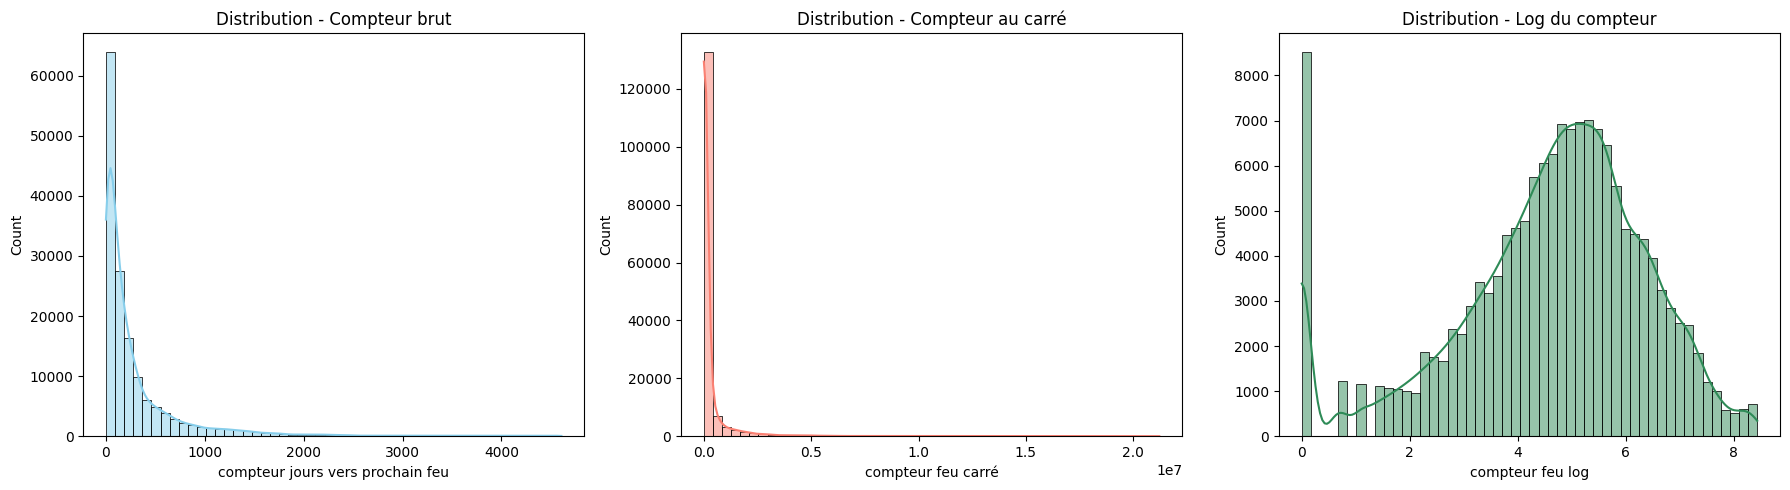

In [33]:
# visualisation
plt.figure(figsize=(18, 5))

# Distribution originale
plt.subplot(1, 3, 1)
sns.histplot(df_merge["compteur jours vers prochain feu"], bins=50, kde=True, color="skyblue")
plt.title("Distribution - Compteur brut")

# Carré
plt.subplot(1, 3, 2)
sns.histplot(df_merge["compteur feu carré"], bins=50, kde=True, color="salmon")
plt.title("Distribution - Compteur au carré")

# Logarithme
plt.subplot(1, 3, 3)
sns.histplot(df_merge["compteur feu log"], bins=50, kde=True, color="seagreen")
plt.title("Distribution - Log du compteur")

plt.tight_layout()
plt.show()

In [34]:

# Trier par ville et par date
df_merge = df_merge.sort_values(['ville', 'Date'])

# Fonction pour compter les jours consécutifs sans pluie
def compter_jours_sans_pluie(groupe):
    compteur = 0
    jours_sans_pluie = []
    for rr in groupe['RR']:
        if pd.isna(rr):
            jours_sans_pluie.append(np.nan)
        elif rr == 0:
            compteur += 1
            jours_sans_pluie.append(compteur)
        else:
            compteur = 0
            jours_sans_pluie.append(compteur)
    return jours_sans_pluie

# Appliquer par ville
df_merge['jours_sans_pluie'] = df_merge.groupby('ville').apply(compter_jours_sans_pluie).explode().astype(float).values

C:\Users\m_bar\AppData\Local\Temp\ipykernel_154012\3432562024.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merge['jours_sans_pluie'] = df_merge.groupby('ville').apply(compter_jours_sans_pluie).explode().astype(float).values


In [35]:

# Fonction pour compter les jours consécutifs avec TX > 30
def compter_jours_chauds(groupe):
    compteur = 0
    jours_chauds = []
    for tx in groupe['TX']:
        if pd.isna(tx):
            jours_chauds.append(np.nan)
        elif tx > 30:
            compteur += 1
            jours_chauds.append(compteur)
        else:
            compteur = 0
            jours_chauds.append(compteur)
    return jours_chauds

# Appliquer la fonction par ville
df_merge= df_merge.sort_values(['ville', 'Date'])  # Assurer l'ordre temporel
df_merge['jours_TX_sup_30'] = df_merge.groupby('ville').apply(compter_jours_chauds).explode().astype(float).values

C:\Users\m_bar\AppData\Local\Temp\ipykernel_154012\2308045979.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merge['jours_TX_sup_30'] = df_merge.groupby('ville').apply(compter_jours_chauds).explode().astype(float).values


In [36]:
# Évapotranspiration Potentielle journalière moyenne sur 7jrs
df_merge["ETPGRILLE_7j"] = df_merge.groupby("ville")["ETPGRILLE"].transform(lambda x: x.rolling(7, min_periods=1).mean())


In [39]:

from geopy.distance import geodesic

# Chargement du fichier CSV
df_merge = pd.read_csv("dataset_modele_decompte2.csv", sep=';', low_memory=False)

# Colonnes météo à compléter
colonnes_meteo = [
    'RR', 'DRR', 'TN', 'HTN', 'TX', 'HTX', 'TM', 'TMNX', 'TNSOL', 'TN50',
    'TAMPLI', 'TNTXM', 'FFM', 'FXI', 'DXI', 'HXI', 'FXY', 'DXY', 'HXY',
    'FXI3S', 'HXI3S', 'UN', 'HUN', 'UX', 'HUX', 'DHUMI40', 'DHUMI80',
    'TSVM', 'UM', 'ORAG', 'BRUME', 'ETPMON', 'ETPGRILLE'
]

# Séparer les lignes avec et sans données météo
df_manquantes = df_merge[df_merge[colonnes_meteo].isnull().any(axis=1)].copy()
df_completes = df_merge.dropna(subset=colonnes_meteo).copy()

# Fonction pour trouver la ville la plus proche avec données météo
def trouver_ville_proche(row, ref_df):
    if pd.isna(row['latitude']) or pd.isna(row['longitude']):
        return None

    ville_ref = ref_df[['ville', 'latitude', 'longitude']].dropna().drop_duplicates()
    coord = (row['latitude'], row['longitude'])

    ville_ref['distance'] = ville_ref.apply(
        lambda x: geodesic(coord, (x['latitude'], x['longitude'])).km, axis=1
    )

    plus_proche = ville_ref.loc[ville_ref['distance'].idxmin()]
    return plus_proche['ville']

# Associer une ville de référence à chaque ligne manquante
df_manquantes['ville_proche'] = df_manquantes.apply(
    lambda x: trouver_ville_proche(x, df_completes), axis=1
)

# Copier les valeurs météo depuis la ville proche
# Fonction robuste de récupération des données météo
def recuperer_donnees_meteo(row, df_source, max_villes=5):
    if pd.isna(row['latitude']) or pd.isna(row['longitude']):
        return pd.Series([None] * len(colonnes_meteo), index=colonnes_meteo)

    # Calcul des distances vers toutes les villes avec données météo
    coord = (row['latitude'], row['longitude'])
    villes_ref = df_source[['ville', 'latitude', 'longitude']].dropna().drop_duplicates().copy()

    villes_ref['distance'] = villes_ref.apply(
        lambda x: geodesic(coord, (x['latitude'], x['longitude'])).km, axis=1
    )

    # Trier par proximité
    villes_proches = villes_ref.sort_values('distance').head(max_villes)

    # Chercher une ville avec données pour cette date
    for _, ville_row in villes_proches.iterrows():
        ville = ville_row['ville']
        meme_jour = df_source[
            (df_source['ville'] == ville) & (df_source['Date'] == row['Date'])
        ]
        if not meme_jour.empty:
            return meme_jour[colonnes_meteo].iloc[0]

    # Si aucune ville ne convient
    return pd.Series([None] * len(colonnes_meteo), index=colonnes_meteo)



# Appliquer proprement les remplacements
for idx, row in df_manquantes.iterrows():
    valeurs_remplacement = recuperer_donnees_meteo(row, df_completes)
    for col in colonnes_meteo:
        if pd.isna(df_manquantes.at[idx, col]) and pd.notna(valeurs_remplacement[col]):
            df_manquantes.at[idx, col] = valeurs_remplacement[col]


# Fusion des deux ensembles pour un dataframe complet
df_final = pd.concat([
    df_completes,
    df_manquantes
]).sort_index()

# Export possible si besoin
# df_final.to_csv("dataset_complet_meteo.csv", sep=';', index=False)


In [ ]:
df_final.to_csv('output/corse_dataset_modele_full.csv', index=False, sep=';')

In [47]:
# print("Bucket utilisé :", bucket)
# s3 = boto3.client(
#     "s3",
#     aws_access_key_id=aws_access_key_id,
#     aws_secret_access_key=aws_secret_access_key,
#     region_name=region
# )
# s3.upload_file("dataset_modele_decompte.csv", bucket, "dataset_modele_decompte.csv")

In [48]:

# import json

# # Chemin vers votre fichier JSON
# file_path = 'best_xgb_model.json'

# # Charger le fichier JSON
# with open(file_path, 'r', encoding='utf-8') as file:
#     model = json.load(file)

